# Age recognition with regression

## Import essential pckg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import os
import sys
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import KFold, train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import initializers
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer
from tensorflow.keras.callbacks import Callback

## Load data

In [2]:
image_path = os.path.abspath(os.getcwd()) + '/face_age/'
X = []
Y = []

# Preprocessing 

## Resizing images and converting them to RGB 

In [3]:
def progressBar(count_value, total):
    bar_length = 100
    filled_up_Length = int(round(bar_length * count_value / float(total)))
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    percentage = round(100.0 * count_value / float(total), 1)
    sys.stdout.write('\r')
    sys.stdout.write("Processing Images: [%-20s] %d%%  %d/%d" % (bar, percentage, count_value, total))
    sys.stdout.flush()

In [4]:
width = 100
height = 100

In [6]:

i = 0
for folder_name,_,filenames in os.walk(image_path):    
    if folder_name !="face_age" and folder_name != 'Data':
        for file in filenames:
            i+=1
            progressBar(i, 19551)
            file_path = folder_name +"/"+ file
            image = Image.open(file_path)
            image = image.convert('RGB')
            image = image.resize((width, height))
            X.append(np.array(image))
            Y.append(int(folder_name[-3:]))
    else:
        pass

Processing Images:  [====================================================================================================] 100%  19551/19551

## Normalise input data to range [0,1]

In [7]:
X = np.array(X)
X = X.astype('float32')
X /= 255.0
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))
Y = np.array(Y)

Min: 0.000, Max: 1.000


## Save preprocessed data

In [5]:
# Save data to folder 
#np.save('Data/X.npy', X)
#np.save('Data/Y.npy',Y)

# Load data from folder
X = np.load('Data/X.npy')
Y = np.load('Data/Y.npy')
print(X.shape)

(19551, 100, 100, 3)


## Train, Test, Validation split data with KFold

In [6]:
# Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

## Specify hyperparameters

In [7]:
# hyperparameters
filter_count = 16
lr = 0.01
epochs = 100
input_shape =[width,height]
hidden_nodes = 100

## Build model

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(X[0].shape))

In [9]:
model.add(tf.keras.layers.Conv2D(
                        kernel_size=(5,5),
                        filters = filter_count,
                        strides=2,
                        padding='SAME',
                        activation=tf.nn.relu,
                        kernel_initializer=initializers.GlorotNormal(),
                        bias_initializer=tf.zeros_initializer()
))

In [10]:
model.add(tf.keras.layers.Conv2D(
                        filters=filter_count/2,
                        kernel_size=1,
                        strides=1,
                        padding='SAME',
                        activation=tf.nn.relu,
                        kernel_initializer=initializers.GlorotNormal(),
                        bias_initializer=tf.zeros_initializer()
))

In [11]:
model.add(tf.keras.layers.Conv2D(
                        kernel_size=1,
                        filters = filter_count,
                        strides=1,
                        padding='SAME',
                        activation=tf.nn.relu,
                        kernel_initializer=initializers.GlorotNormal(),
                        bias_initializer=tf.zeros_initializer()
))

In [12]:
model.add(tf.keras.layers.BatchNormalization(
                        center=True,
                        scale=True
))

In [13]:
model.add(tf.keras.layers.MaxPool2D(
                        pool_size=(2, 2),
                        strides=2,
                        padding='VALID'
))

In [14]:
model.add(tf.keras.layers.Conv2D(
                        filters=filter_count*2,
                        kernel_size=5,
                        strides=1,
                        padding='SAME',
                        activation=tf.nn.relu,
                        kernel_initializer=initializers.GlorotNormal(),
                        bias_initializer=tf.zeros_initializer()
))

In [15]:
model.add(tf.keras.layers.BatchNormalization(
                        center=True,
                        scale=True
))

In [16]:
model.add(tf.keras.layers.MaxPool2D(
                        pool_size=(2, 2),
                        strides=2,
                        padding='VALID',
))

In [17]:
model.add(tf.keras.layers.Flatten())

In [18]:
model.add(tf.keras.layers.Dense(
                        units = hidden_nodes,
                        activation=tf.nn.relu,
                        kernel_initializer=initializers.GlorotNormal(),
                        bias_initializer=tf.zeros_initializer(),
))

In [19]:
model.add(tf.keras.layers.BatchNormalization(
                        center=True,
                        scale=True
))

In [20]:
model.add(tf.keras.layers.Dense(
                        units=1,
                        activation=tf.nn.relu,
                        kernel_initializer=initializers.GlorotNormal(),
                        bias_initializer=tf.zeros_initializer(),
))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 8)         136       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        144       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        1

In [21]:
model.compile(optimizer="Adam", loss="mse", metrics=["mae", "acc"])

## Check physical devices 

In [22]:
# Check if GPU is available
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Create callbacks

In [23]:
datagen = ImageDataGenerator(
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True)

early_stopping = EarlyStopping(
                                patience=5,
                                min_delta = 0.01,
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                monitor="val_loss",
                                patience=3,
                                episilon= 0.01,
                                factor=0.1,
                                cooldown = 4,
                                verbose=1)

## Train model

In [24]:
model_save_path = os.path.join(os.getcwd(), "model") 

In [25]:
cv_scores = []
hostory_data = {}
fold_num = 1
for train_idx, test_idx in kfold.split(X, Y):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    history = model.fit(datagen.flow(X_train, Y_train), 
                        epochs=50, 
                        validation_data=(X_test, Y_test), 
                        callbacks=[reduce_learning_rate, early_stopping])
    model.save(os.path.join(model_save_path,f"model_{fold_num}.tf"),
           overwrite=True,
           include_optimizer=True,
           save_format="h5")
    # Evaluate the model on the test set
    accuracy = model.evaluate(X_test, Y_test)
    cv_scores.append(accuracy)
    hostory_data[fold_num] = {"mae" : history.history['mae'], "val_mae" : history.history['val_mae']}
    fold_num += 1

Epoch 1/50
489/489 [==============================] - 32s 58ms/step - loss: 517.5413 - mae: 15.9358 - acc: 0.0139 - val_loss: 334.7079 - val_mae: 12.5856 - val_acc: 0.0066
Epoch 2/50
489/489 [==============================] - 27s 55ms/step - loss: 182.8907 - mae: 9.6810 - acc: 0.0096 - val_loss: 161.3767 - val_mae: 9.4094 - val_acc: 0.0222
Epoch 3/50
489/489 [==============================] - 27s 55ms/step - loss: 151.7380 - mae: 8.8197 - acc: 0.0141 - val_loss: 124.4009 - val_mae: 8.0362 - val_acc: 0.0151
Epoch 4/50
489/489 [==============================] - 27s 56ms/step - loss: 125.9868 - mae: 8.0517 - acc: 0.0145 - val_loss: 106.2623 - val_mae: 7.5469 - val_acc: 0.0197
Epoch 5/50
489/489 [==============================] - 28s 57ms/step - loss: 115.4864 - mae: 7.7317 - acc: 0.0196 - val_loss: 106.2567 - val_mae: 7.6961 - val_acc: 0.0353
Epoch 6/50
489/489 [==============================] - 28s 57ms/step - loss: 107.5289 - mae: 7.4651 - acc: 0.0189 - val_loss: 298.7245 - val_mae: 13.

489/489 [==============================] - 27s 55ms/step - loss: 71.8376 - mae: 6.1798 - acc: 0.0214 - val_loss: 44.5199 - val_mae: 4.9369 - val_acc: 0.0136
Epoch 9/50
489/489 [==============================] - 27s 55ms/step - loss: 73.0420 - mae: 6.2203 - acc: 0.0217 - val_loss: 44.4708 - val_mae: 4.9407 - val_acc: 0.0133
Epoch 00009: early stopping
123/123 [==============================] - 1s 4ms/step - loss: 44.4708 - mae: 4.9407 - acc: 0.0133
Epoch 1/50
489/489 [==============================] - 28s 57ms/step - loss: 68.5440 - mae: 6.0460 - acc: 0.0208 - val_loss: 50.8023 - val_mae: 5.0183 - val_acc: 0.0125
Epoch 2/50
489/489 [==============================] - 27s 56ms/step - loss: 68.1583 - mae: 6.0278 - acc: 0.0215 - val_loss: 48.5013 - val_mae: 4.9348 - val_acc: 0.0123
Epoch 3/50
489/489 [==============================] - 28s 56ms/step - loss: 69.7126 - mae: 6.0561 - acc: 0.0222 - val_loss: 48.2788 - val_mae: 4.9701 - val_acc: 0.0107
Epoch 4/50
489/489 [========================

## Statistics 

In [26]:
cv_scores = np.array(cv_scores)
split = np.hsplit(cv_scores, 3)
loss_stats = split[0]
mae_stats = split[1]
acc_stats = split[2]

In [27]:
mean_accuracy = np.mean(mae_stats)
std_accuracy = np.std(mae_stats)
print("Cross-Validation MAE: %0.2f (+/- %0.2f)" % (mean_accuracy, std_accuracy))

Cross-Validation MAE: 5.08 (+/- 0.26)


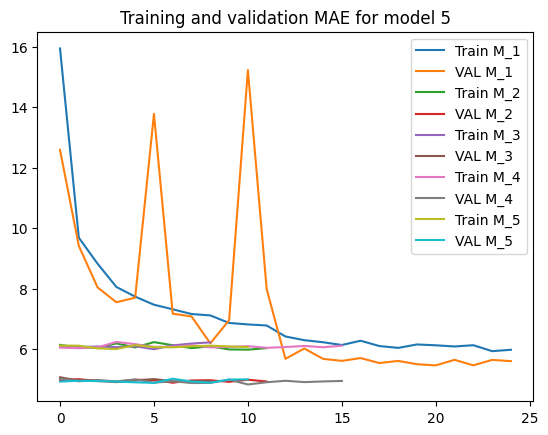

In [30]:
for item in hostory_data:
    epochs = [i for i in range(0,len(hostory_data[item]["mae"]))]
    plt.plot(epochs, hostory_data[item]["mae"], label=f'Train M_{item}')
    plt.plot(epochs, hostory_data[item]["val_mae"], label=f'VAL M_{item}')
    plt.title(f'Training and validation MAE for model {item}')
    plt.legend()
    plt.savefig(os.path.join(os.getcwd(), "fig", f"fig_{item}.jpg"))